Genetic Algorithm by Aftersol

This algorithm run the genetic algorithm to find the maximum point of this function below:

$$\left(f(x,y)=(1-x)^2*exp(-x^2-(y+1)^2)-(x-x^3-y^3)*exp((-x^2-y^2))\right)$$

Where $$-2<=x,y<=2$$


where parameters for the variables x and y falls between -2 and +2.

[Reference on Maximum Point on the below function on WolfRam](https://www.wolframalpha.com/input?i=maximum+of+f%28x%2Cy%29%3D+%281-x%29%5E2*e%5E%28-x%5E2-%28y%2B1%29%5E2%29-%28x-x%5E3-y%5E3%29e%5E%28-x%5E2-y%5E2%29++for+-2+%3C%3Dx+%3C%3D2+and+for+-2%3C%3Dy+%3C%3D2)

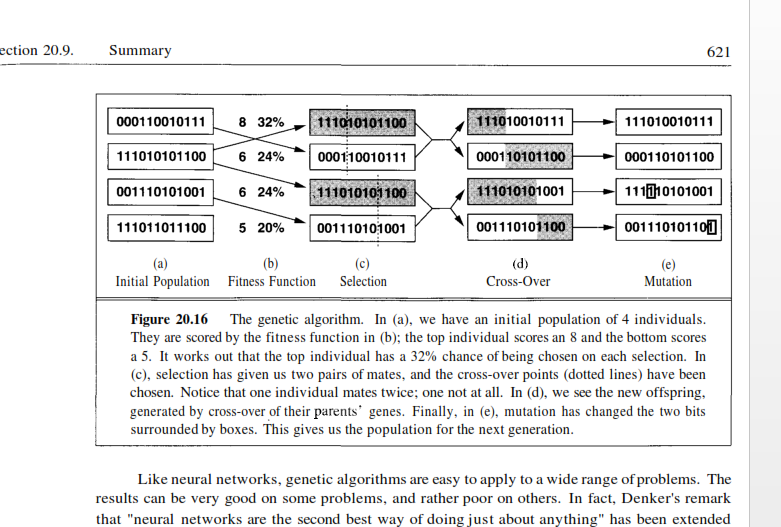

In [ ]:
# Genetic Algorithm by Aftersol 2024
# based on this diagram form this post: https://stackoverflow.com/q/23533719

# Roulette Wheel code Gareth Latty https://stackoverflow.com/a/10324090

# Thank you user3508182, Intelligent Systems and Soft Computing slide authors, and Gareth Latty for giving me the resourecs needed to implement my genetic algorithm

# HW Link: https://colab.research.google.com/drive/1700-OEl1WzIHmwC3JJlpSlPet_rFZmZQ

import numpy as np
from matplotlib import pyplot as plt

from copy import deepcopy # for copying chromosones into new generation

class chromosome:

  def __init__(self,x,y):
    # contains two x and y 8 bits to be decoded for calculating two dimensional functions that takes x and y decoded numbers from -2.0 to 2.0 respectively
    self.x = np.uint8(x)
    self.y = np.uint8(y)

  def __str__(self):
    return f"{decode(self.x)} {decode(self.y)}"

# Settings for the genetic algorithm

elite_selection = True # enable elite selection for choosing two best chromosomes

current_generation = 0 # Starting generation
generation = 200 # How many generations to run for? (generation - current_generation) = generations to run for

# Range to limit input to decoding function
# Increasing range will decrease accuracy because of decoding 8 bit integer numbers into x and y

left_limit = -2.0
right_limit = 2.0

# Probability Variables based on numpy random() which generates from 0.0-1.0
crossover_prob = 0.7 # probabity of crossover
mutation_prob = 0.01 # probabity of mutations

# genetic algorithm global variables

# Chromosones and fitness array variables for each generation
population = [None,None,None,None,None,None,None,None]
decoded_x = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
decoded_y = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

fitness = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
fitness_ratio = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

# Best chromosones out of all generations
best_generation = 0
best_x = 0.0
best_y = 0.0
best_fitness = 0.0
best_fitnesses = list()

best_generation_not_equal_to_each_other = 0
best_x_not_equal_to_each_other = 0.0
best_y_not_equal_to_each_other = 0.0
best_fitness_not_equal_to_each_other = 0.0

def calculate_fitness(x,y) -> float: # change fitness function here
  return np.power(1.0 - x, 2.0) * np.exp(-np.power(x, 2.0) - np.power(y + 1.0, 2.0))\
  -(x - np.power(x, 3.0) - np.power(y, 3.0)) * np.exp(-np.power(x, 2.0) - np.power(y, 2.0))

def decode(x : np.uint8) -> float:
  return float(x)*((right_limit - left_limit)/255.0) + left_limit # (r-l/(2^bitstring_length + l))

def crossover(a,b) -> list: # one point crossover function
  pos = np.random.randint(0,15)

  # Merge two 8 bit numbers into 16 bits to perform bitwise one point crossover operations
  a_u16 = np.uint16((a.x << 8) | a.y)
  b_u16 = np.uint16((b.x << 8) | b.y)

  mask = np.uint16(65535) # create a mask filled with 1's

  l_mask = (mask << pos) #shift left/right to create 0's for bitwise AND masking
  r_mask = (mask >> (16-pos))

  temp = a_u16; # swap parts of bitstring with each other
  a_u16 = (a_u16 & l_mask) | (b_u16 & r_mask)
  b_u16 = (b_u16 & l_mask) | (temp & r_mask)

  a.x = (a_u16 & 65280) >> 8 # shift x back
  a.y = (a_u16 & 255) # mask left side out

  b.x = (b_u16 & 65280) >> 8 # shift x back
  b.y = (b_u16 & 255) # mask left side out

  return a, b

def mutate_candiate(candidate) -> chromosome: # This function flip one gene by using XOR to create variability
  test_mutation = np.random.random()

  if test_mutation <= mutation_prob: # Will it mutate?

    pos = np.uint8(np.random.uniform(0,15))

    #print(f"mutating at {pos} for candidate {i}")

    if pos < 8:
      candidate.x = candidate.x ^ (np.uint8(1) << pos)
    else:
      pos = pos % 8
      candidate.y = candidate.y ^ (np.uint8(1) << (pos))
  return candidate

def getIndexWeighted(arr : list) -> int:  # roulette wheel selection from Gareth Latty's code
                                          # https://stackoverflow.com/a/10324090
  max_fitness = sum(arr)

  fitness_counter = 0.0
  arrSize = len(arr)

  threshold = np.random.uniform(0.0, max_fitness)
  #print (threshold)
  for f in range(arrSize):
    fitness_counter = fitness_counter + arr[f]
    if fitness_counter >= threshold:
      return f

  return arr[arrSize-1]

np.random.seed() # fixed seed for testing genetic algorithm for changes

for i in range(8):
  population[i] = chromosome(np.uint8(np.random.randint(0,255)),\
                             np.uint8(np.random.randint(0,255)))



# This while loop code runs a single run of the genetic algorithm
while current_generation < generation:
  total = 0.0 # total fitness of all chromosones

  newGeneration = list()

  decoded_x = [decode(p.x) for p in population]
  decoded_y = [decode(p.y) for p in population]

  for i in range(8):
    fitness[i] = calculate_fitness(decoded_x[i], decoded_y[i])

  best_fitness_index = np.argmax(fitness) # get index of max
  print(f"Generation {current_generation}")
  print(fitness)



  print(f"Best x: {decoded_x[best_fitness_index]}")
  print(f"Best y: {decoded_y[best_fitness_index]}")

  print(f"Best fitness: {fitness[best_fitness_index]}")

  if (fitness[best_fitness_index]>best_generation_not_equal_to_each_other and population[best_fitness_index].x != population[best_fitness_index].y):
    best_generation_not_equal_to_each_other = current_generation

    best_x_not_equal_to_each_other = decode(population[best_fitness_index].x)
    best_y_not_equal_to_each_other = decode(population[best_fitness_index].y)

    best_fitness_not_equal_to_each_other = fitness[best_fitness_index]

  if (fitness[best_fitness_index]>best_fitness):
    best_generation = current_generation
    best_fitness = fitness[best_fitness_index]

    best_x = decode(population[best_fitness_index].x)
    best_y = decode(population[best_fitness_index].y)

  best_fitnesses.append(fitness[best_fitness_index])
  ranking = np.argsort(fitness)

  worst_fitness = min(fitness)
  print(worst_fitness)

  if (worst_fitness < 0.0):
    fitness = [f - (worst_fitness - 0.001) for f in fitness]

  print(fitness)
  print(ranking)

  total = sum(fitness) # get the sum of the fitness of all chromosomes for averaging fitness

  fitness_ratio = [(f / total) * 100.0 for f in fitness] # calculate total ratio of the fitness all chromosomes

  #print(fitness_ratio)

  # elite selection clones the best two chromosome
  if (elite_selection == True):
    print(f"Picking best X: {decode(population[ranking[7]].x)} Y: {decode(population[ranking[7]].y)} Fitness: {fitness[ranking[7]]}")
    print(f"Picking second best X: {decode(population[ranking[6]].x)} Y: {decode(population[ranking[6]].y)} Fitness: {fitness[ranking[6]]}")

    newGeneration.append(chromosome(population[ranking[7]].x,population[ranking[7]].y))
    newGeneration.append(chromosome(population[ranking[6]].x,population[ranking[6]].y))

  while len(newGeneration) < 8: # run this loop until population are filled up
    # selects candidates based on roulette wheel
    parents = [getIndexWeighted(fitness_ratio),getIndexWeighted(fitness_ratio)]
    candidate = [chromosome(population[parents[0]].x,population[parents[0]].y),\
                 chromosome(population[parents[1]].x,population[parents[1]].y)]

    test_crossover = np.random.random()

    for i in range(2):
      candidate[i] = mutate_candiate(candidate[i]) # modify chromosones to attempt to be better

      #print(f"Candidate 0: {decode(candidate[0].x)}, {decode(candidate[0].y)}")
      #print(f"Candidate 1: {decode(candidate[1].x)}, {decode(candidate[1].y)}")

    if test_crossover <= crossover_prob: # Will it crossover
      #print(f"crossing over candidate 0 x:{decode(candidate[0].x)} y:{decode(candidate[0].y)} with candidate 1 x:{decode(candidate[1].x)} y:{decode(candidate[1].y)}")

      # create two chromosones based on mixing of candidates' genes into new generation
      offspring_pair = crossover(candidate[0], candidate[1])

      #print(f"Crossover 0: {decode(offspring_pair[0].x)}, {decode(offspring_pair[0].y)}")
      #print(f"Crossover 1: {decode(offspring_pair[1].x)}, {decode(offspring_pair[1].y)}")

      newGeneration.append(offspring_pair[0])
      newGeneration.append(offspring_pair[1])

    else: # clone candidates into new generation
      #print(f"Clone 0: {decode(candidate[0].x)}, {decode(candidate[0].y)}")
      #print(f"Clone 1: {decode(candidate[1].x)}, {decode(candidate[1].y)}")

      newGeneration.append(candidate[0])
      newGeneration.append(candidate[1])

  for c in range(8):
    print(newGeneration[c])

  population = deepcopy(newGeneration) # set up new generation
  #population = population[:8] # cut population to 8

  current_generation = current_generation + 1 # start new generation

# Print the best chromosones of all generations

print(f"\nBest chromosone for X != Y:\nGeneration:{best_generation_not_equal_to_each_other}\nX:{best_x_not_equal_to_each_other}\nY:{best_y_not_equal_to_each_other}\nFitness:{best_fitness_not_equal_to_each_other}")


print(f"\nBest chromosone:\nGeneration:{best_generation}\nX:{best_x}\nY:{best_y}\nFitness:{best_fitness}")


# Plot graph of the result of best fitness of chromosones within generations

x = np.arange(0,generation)

plt.title("Genetic Algorithm Result")

plt.xlabel("Generation")
plt.ylabel("Best Fitness")

plt.plot(x,best_fitnesses)
plt.show()

plt.close()